- 2020.07.16 : Kouui

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
import sys
sys.path.append("../../")

%load_ext autoreload
%autoreload 2

from src.Structure import AtomCls, AtmosphereCls
from src.Atomic import PhotoIonize, Collision
from src.Atomic import LTELib, BasicP#, SEsolver
#from src.RadiativeTransfer import Profile
#from src.Math import Integrate
#from src import Constants as Cst

#from src.Visual import Grotrian

#from src.Util import Class

from Lib import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
folder = "../../data/atom/Ca_II/"
file_Level     = folder + "Ca_II.Level"
file_Aji = folder + "Einstein_A/Nist.Aji"
file_CEe = folder + "Collisional_Excitation/RH.Electron"
atom = AtomCls.Atom(file_Level, _file_Aji=file_Aji, _file_CEe=file_CEe)

file_CIe = folder + "Collisional_Ionization/RH.Electron"
atom.read_CI(_path_electron=file_CIe)

file_PI  = folder + "Photoionization/RH.Alpha"
atom.read_PI(_path_alpha=file_PI)

file_Rad = folder + "Ca_II.RadiativeLine"
atom.read_RadiativeLine_and_make_Line_Mesh(_path=file_Rad)
atom.make_Cont_Mesh()
atom.read_RadLine_intensity(_folder="../../data/intensity/Ca_II/")

Reading Einstein Aji coefficient from : 
 ../../data/atom/Ca_II/Einstein_A/Nist.Aji
...
Finished.

Reading Electron impact Effective Collisional Strength from : 
 ../../data/atom/Ca_II/Collisional_Excitation/RH.Electron
Finished.

Reading Electron impact Collisional Ionization coefficient from : 
 ../../data/atom/Ca_II/Collisional_Ionization/RH.Electron
Finished.

Reading Photoionization cross section from : 
 ../../data/atom/Ca_II/Photoionization/RH.Alpha
Finished.

Reading Radiative Line information from : 
 ../../data/atom/Ca_II/Ca_II.RadiativeLine
line mesh prepared.
continuum mesh prepared.


In [7]:
slab0d = AtmosphereCls.AtmosphereC0d(Te=1E4, Vt=5.E5, Ne=1E12, Vd=0E5)
slab0d.readBackgroundIntensity('../../data/intensity/continuum/ASTM_E490+PROM7_HI_CaII.dat')

---

In [24]:
#--- 
# interpolate 
# - continuum intensity 
# - photoionization cross section 
# to compute photoionization rate
#
# assume : this intensity profile will not be affected by Doppler shift
#---
PI_I = PhotoIonize.interpolate_PI_intensity(slab0d.BackRad[:,:], 
                                            atom.Mesh.Cont)
PI_alpha = PhotoIonize.interpolate_PI_alpha(atom.PI.alpha_table, 
                                            atom.Mesh.Cont)


#--- 
# - compute Level gamma
# - compute Line Gamma
#---
BasicP.get_Level_gamma(Aji=_atom.Line.AJI[:],idxJ=_atom.Line.idxJ[:],
                       gamma=_atom.Level.gamma[:])
BasicP.get_Line_Gamma(idxI=_atom.Line.idxI[:], idxJ=_atom.Line.idxJ[:],
                    gamma=_atom.Level.gamma[:], Gamma=_atom.Line.Gamma[:])

In [12]:
#--- 
# physical parameters
#---
_atom = atom
_Te = slab0d.data.Te
_Te = 8000
_Ne = slab0d.data.Ne
_Ne = 1E12
_Vt = slab0d.data.Vt
_Vt = 5E5
_Vd = slab0d.data.Vd
_Vd = 100E5 # 100 [km/s]

In [23]:
#--- 
# compute LTE population ratio for each CE transition
#---
_n_LTE, _ni_LTE, _nj_LTE = ni_nj_LTE(_Level=atom.Level, 
                                     _Line=atom.Line, 
                                     _Cont=atom.Cont, 
                                     _Te=_Te, 
                                     _Ne=_Ne)

In [18]:
#--- 
# compute bound-free radiative transition rate coefficient
#    - photoionization
#    - spontaneous radiative recombination
#    - stimulated radiative recombination
#---
_Rik, _Rki_stim, _Rki_spon = bf_R_rate(_waveMesh=atom.Mesh.Cont, 
                                       _Jnu=[0.5*x for x in PI_I], 
                                       _alpha=PI_alpha, 
                                       _Te=_Te, 
                                       _ni_LTE=_ni_LTE[_nLine:], 
                                       _nj_LTE=_nj_LTE[_nLine:])

In [55]:
#--- 
# compute bound-bound radiative transition rate coefficient
#    - spontaneous radiative de-excitation (Aji)
#    - radiative excitation                (Bij * J)
#    - stimulated radiative de-excitation  (Bji * J)
#---

_Bij_Jbar, _Bji_Jbar = B_Jbar(_Level=atom.Level, 
                              _Line=atom.Line, 
                              _lineIndex=atom.I_Rad.lineIndex, 
                              _MeshRadLine=atom.Mesh.RadLine, 
                              _Te=_Te, 
                              _Vt=_Vt,
                              _Vd=_Vd,
                              _Mass=atom.Mass, 
                              _I_cm=atom.I_Rad.I_cm, 
                              _Jbar=None)

In [26]:
#--- 
# compute collision 
#    - excitation/de-excitation 
#    - ionization/recombination
# rate coefficient
#---
_CEij = CEij_rate_coe(_Omega_table=atom.CE.Omega_table[:,:], 
                      _Te_table=atom.CE.Te_table[:], 
                      _Coe=atom.CE.Coe, 
                      _Te=_Te)
_CIik = CIik_rate_coe(_Omega_table=atom.CI.Omega_table[:,:], 
                      _Te_table=atom.CI.Te_table[:], 
                      _Coe=atom.CI.Coe, 
                      _Te=_Te)
_Cij = np.append( _CEij[:], _CIik[:] )
_Cji = Collision.Cij_to_Cji(_Cij=_Cij[:],  
                            _ni_LTE=_ni_LTE[:], 
                            _nj_LTE=_nj_LTE[:])

## Plots

### Te, Ne v.s. collisional excitation

In [38]:
atom.I_Rad.lineIndex

array([2, 3, 5, 6, 8], dtype=uint32)

In [ ]:
Te_arr = np.logspace(3.5, 5, 101,endpoint=True)
#Ne_arr = np.logspace(9, 14, 101, endpoint=True)
nTe = Te_arr.shape[0]
#nNe = Ne_arr.shape[0]

CEij_arr = np.zeros((_nLine, nTe))

for k in range(nTe):
    CEij_arr[:,k] = CEij_rate_coe(_Omega_table=atom.CE.Omega_table[:,:], 
                      _Te_table=atom.CE.Te_table[:], 
                      _Coe=atom.CE.Coe, 
                      _Te=Te_arr[k])

Text(0,0.5,'CEij [$s^{-1}cm^{3}$]')

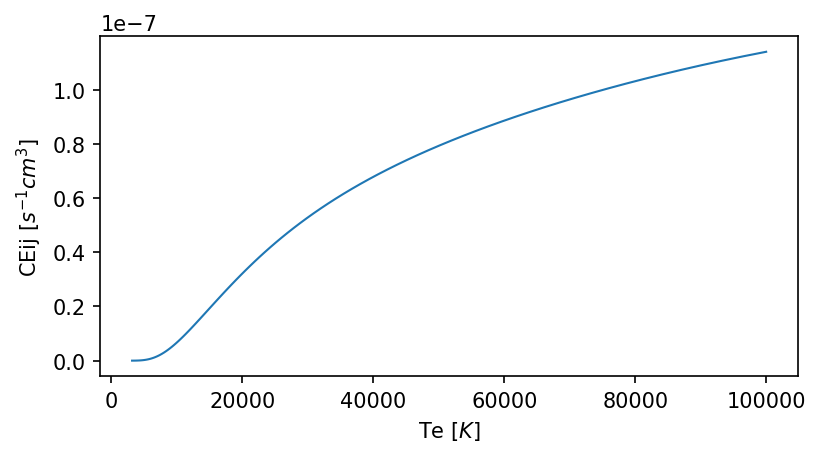

In [47]:
names = [f"{atom.Line.w0_AA[i]:.0f}" for i in atom.I_Rad.lineIndex]
index = [i for i in atom.I_Rad.lineIndex]

k = 0

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=150)
ax.plot(Te_arr, CEij_arr[index[k],:], linewidth=1, label=names[k])

ax.set_xlabel("Te [$K$]")
ax.set_ylabel("CEij [$s^{-1}cm^{3}$]")
ax.legend(loc="best")
plt.show()

### photo-excitation v.s. collisional excitation

In [67]:
# electron temperature
Te_arr = np.logspace(3.5, 5, 101,endpoint=True)
nT = Te_arr.shape[0]
# radiation temperature
Tr_arr = np.linspace(1E3, 1E4, 101,endpoint=True)

#Jbar_arr = np.zeros((atom.nRadiativeLine, nTe))
Bij_Jbar_arr = np.zeros((atom.nRadiativeLine, nTe))
CEij_arr = np.zeros((_nLine, nTe))

for k in range(nT):
    CEij_arr[:,k] = CEij_rate_coe(_Omega_table=atom.CE.Omega_table[:,:], 
                      _Te_table=atom.CE.Te_table[:], 
                      _Coe=atom.CE.Coe, 
                      _Te=Te_arr[k])
    
    Jbar = LTELib.Planck_cm(atom.Line.w0[atom.I_Rad.lineIndex],Tr_arr[k])
    Bij_Jbar_arr[:,k], _Bji_Jbar = B_Jbar(_Level=atom.Level, 
                                  _Line=atom.Line, 
                                  _lineIndex=atom.I_Rad.lineIndex, 
                                  _MeshRadLine=atom.Mesh.RadLine, 
                                  _Te=None, 
                                  _Vt=None,
                                  _Vd=None,
                                  _Mass=None, 
                                  _I_cm=None, 
                                  _Jbar=Jbar)

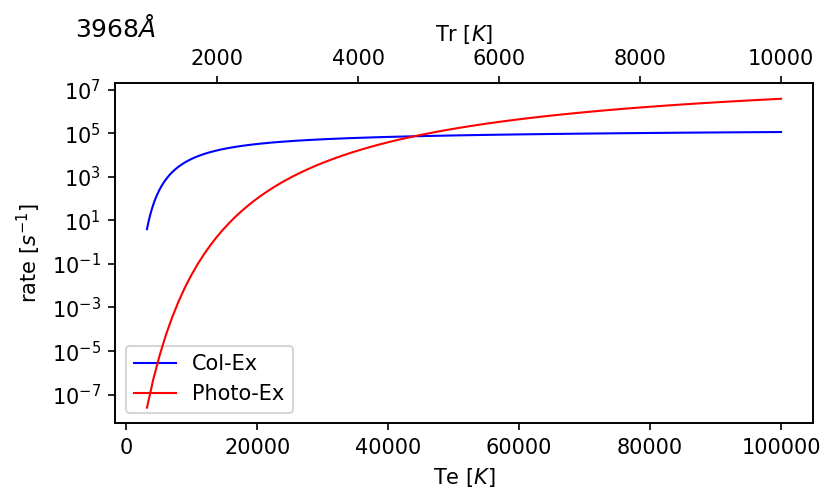

In [75]:
names = [f"{atom.Line.w0_AA[i]:.0f}" for i in atom.I_Rad.lineIndex]
index = [i for i in atom.I_Rad.lineIndex]

k = 0
Ne = 1E12

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=150)
lns1 = ax.plot(Te_arr, Ne*CEij_arr[index[k],:],"b", linewidth=1, label="Col-Ex")
ax2 = ax.twiny()

lns2 = ax2.plot(Tr_arr, Bij_Jbar_arr[k,:],"r", linewidth=1, label="Photo-Ex")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="best")

ax2.set_title(names[k]+"$\AA$", x=0.0, y=1.1)
ax.set_xlabel("Te [$K$]")
ax2.set_xlabel("Tr [$K$]")
ax.set_ylabel("rate [$s^{-1}$]")
ax.set_yscale("log")
plt.show()